##  Feature Engineering & Statistical Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm

### <li> Vrem sa vedem legatura dintre video surveillance pe scoli

In [2]:
data = pd.read_csv("schoolBuildings_Team1.csv")
data.head(1)

,idSchool,Judet,locality,Adresa,id,buildingCode,buildingDescription,builtSurface,heldSurface,constructionYear,propertyType,floorsNo,schoolInternalId,videoSurveillance,audioSurveillance,Numar_elevi_jud
0,11269910,ARAD,ARAD,"121-125 AUREL VLAICU, ARAD, judetul ARAD, 3103...",34136,C1,Gradinita Gosen Arad,1773.73,1469.0,1996,Folosință gratuită de la terți,2,10131270,False,False,211865


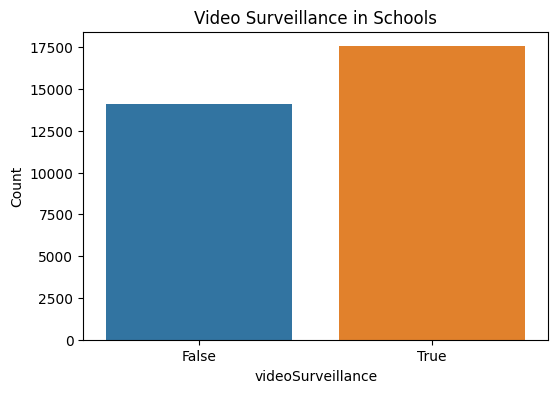

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='videoSurveillance', hue='videoSurveillance', legend=False)
plt.title('Video Surveillance in Schools')
plt.ylabel('Count')
plt.show()

### datele sunt usor dezechilibrate pentru video surveillance


In [4]:
data['videoSurveillance'].value_counts()

videoSurveillance
True     17550
False    14109
Name: count, dtype: int64

In [5]:
# Pastram un numar egal de randuri pentru cele doua categorii din Video Surveillance
video_0 = data[data['videoSurveillance'] == False]
video_1 = data[data['videoSurveillance'] == True].head(len(video_0))

video_0.reset_index(drop=True, inplace=True)
video_1.reset_index(drop=True, inplace=True)

#concatenam intr-un set nou echilibrat
data = pd.concat([video_0, video_1])
data = shuffle(data)
#verificam
data['videoSurveillance'].value_counts()

videoSurveillance
False    14109
True     14109
Name: count, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28218 entries, 13357 to 7418
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idSchool             28218 non-null  int64  
 1   Judet                28218 non-null  object 
 2   locality             28218 non-null  object 
 3   Adresa               28218 non-null  object 
 4   id                   28218 non-null  int64  
 5   buildingCode         28218 non-null  object 
 6   buildingDescription  28218 non-null  object 
 7   builtSurface         28218 non-null  float64
 8   heldSurface          28218 non-null  float64
 9   constructionYear     28218 non-null  int64  
 10  propertyType         28218 non-null  object 
 11  floorsNo             28218 non-null  int64  
 12  schoolInternalId     28218 non-null  int64  
 13  videoSurveillance    28218 non-null  bool   
 14  audioSurveillance    28218 non-null  bool   
 15  Numar_elevi_jud      28218 non-null  i

In [7]:
data["audioSurveillance"] = data["audioSurveillance"].apply(lambda x: 1 if x==True else 0)
data["videoSurveillance"] = data["videoSurveillance"].apply(lambda x: 1 if x==True else 0)
data.head(1)

,idSchool,Judet,locality,Adresa,id,buildingCode,buildingDescription,builtSurface,heldSurface,constructionYear,propertyType,floorsNo,schoolInternalId,videoSurveillance,audioSurveillance,Numar_elevi_jud
13357,11263757,HUNEDOARA,REEA,"84 Principală, REEA, judetul HUNEDOARA, 337494...",7649,C1,C1,153.0,153.0,1954,Administrator UAT,0,10134228,0,0,183650


###############################################################################################################################
### Ce putem lua in considerare in calitate de variabile independente?

<li>constructionYear</li>
<li>propertyType</li>
<li>floorsNo</li>
<li>heldSurface</li>
<li>Judet</li>

### New features to be added?
- <b>buidling_age</b>: current year - constructionYear -> in functie de distributia se pot categorisi intr-un nou feature
- <b>crowding_index (pentru judet) </b>: (held surface total pe judet)/elevi
    
### What to analyse?

-- regresie logistica -> VideoSurveillance 0 sau 1? cand stim informatiile de mai sus

###############################################################################################################################

In [8]:
'''
    Creare new feature building age:
'''
current_year = datetime.now().year

data['building_age'] = current_year - data['constructionYear']

'''
    Creare new feature crowding index pentru judet:
'''
#total helSurface al scolilor pt fiecare judet
total_heldSurface_per_county = data.groupby('Judet')['heldSurface'].sum()
total_students_per_county = data.groupby('Judet')['Numar_elevi_jud'].max()

student_crowding_per_county = ((total_students_per_county / total_heldSurface_per_county).round(2))\
                                                        .reset_index(name='crowding_index_per_county')

data = data.merge(student_crowding_per_county, on='Judet', how='left')
data.head(3)

,idSchool,Judet,locality,Adresa,id,buildingCode,buildingDescription,builtSurface,heldSurface,constructionYear,propertyType,floorsNo,schoolInternalId,videoSurveillance,audioSurveillance,Numar_elevi_jud,building_age,crowding_index_per_county
0,11263757,HUNEDOARA,REEA,"84 Principală, REEA, judetul HUNEDOARA, 337494...",7649,C1,C1,153.00,153.00,1954,Administrator UAT,0,10134228,0,0,183650,69,0.36
1,11270340,CALARASI,CĂLĂRAŞI,"8-12 PRELUNGIREA BUCURESTI, CĂLĂRAŞI, judetul...",26500,002,Anexe,455.55,703.29,1991,Administrator UAT,1,11075421,1,0,147143,32,0.38
2,11274807,HARGHITA,LĂZAREA,"275 NAGYPATAK, LĂZAREA, judetul HARGHITA, 5371...",30467,C1,"GPN, S04",342.00,342.00,1896,Administrator UAT,0,11090090,1,0,174551,127,0.33


In [9]:
data['building_age'].describe()

count    28218.000000
mean        57.639025
std         36.439998
min          0.000000
25%         38.000000
50%         53.000000
75%         72.000000
max        323.000000
Name: building_age, dtype: float64

In [10]:
bins = [-1, 10, 50, 100, 200, float('inf')] 
labels = ['new', 'partially new', 'old', 'very old', 'extremely old']

# Aplicarea categoriilor pe baza coloanei 'constructionYear'
data['building_type'] = pd.cut(data['building_age'], bins=bins, labels=labels, right=False)

In [11]:
data.head(3)

,idSchool,Judet,locality,Adresa,id,buildingCode,buildingDescription,builtSurface,heldSurface,constructionYear,propertyType,floorsNo,schoolInternalId,videoSurveillance,audioSurveillance,Numar_elevi_jud,building_age,crowding_index_per_county,building_type
0,11263757,HUNEDOARA,REEA,"84 Principală, REEA, judetul HUNEDOARA, 337494...",7649,C1,C1,153.00,153.00,1954,Administrator UAT,0,10134228,0,0,183650,69,0.36,old
1,11270340,CALARASI,CĂLĂRAŞI,"8-12 PRELUNGIREA BUCURESTI, CĂLĂRAŞI, judetul...",26500,002,Anexe,455.55,703.29,1991,Administrator UAT,1,11075421,1,0,147143,32,0.38,partially new
2,11274807,HARGHITA,LĂZAREA,"275 NAGYPATAK, LĂZAREA, judetul HARGHITA, 5371...",30467,C1,"GPN, S04",342.00,342.00,1896,Administrator UAT,0,11090090,1,0,174551,127,0.33,very old


### Mai departe calculam tabele de contingenta si cramers'v pentru:
#### videoSurveillance & propertyType/audioSurveillance/buildingType

In [12]:
#chi square
def cramers_v(chi_stat, N, contingency_table):
    minimum_dimension = min(contingency_table.shape)-1
    return np.sqrt((chi_stat/N) / minimum_dimension)

def chi2_test_video_surveillance(y):
    contingency_table = pd.crosstab(data['videoSurveillance'], y)
    chi2, p,_,_ = chi2_contingency(contingency_table)
    print(f"\nResults for video surveillance & {y.name}:")
    print(f"chi2: {chi2}\n P: {p}")
    print(f"And Cramer's V: {cramers_v(chi2, data.shape[0], contingency_table)}\n")
    return chi2
    
propType = chi2_test_video_surveillance(data['propertyType'])
audio = chi2_test_video_surveillance(data['audioSurveillance'])
building = chi2_test_video_surveillance(data['building_type'])


Results for video surveillance & propertyType:
chi2: 72.65428154811832
 P: 2.869722995325297e-14
And Cramer's V: 0.050741989570453554


Results for video surveillance & audioSurveillance:
chi2: 1932.5832660654542
 P: 0.0
And Cramer's V: 0.2617013679721454


Results for video surveillance & building_type:
chi2: 34.02807072573317
 P: 7.353758069507339e-07
And Cramer's V: 0.03472606300197541



### Interpretarea:
<br>
<li>video surveillance & propertyType ==> Avem asociere - dar este foarte slaba</li>
<li>video surveillance & audioSurveillance ==> Avem asociere si este ok </li>
<li>video surveillance & building_type ==> Avem asociere, dar foarte slaba</li>
<br>
    

### Vedem corelatiile dintre videoSurveillance & restul variabilelor de interes

In [13]:
numerical_df = data.select_dtypes(include = ['number'])
numerical_df.drop(columns = ['idSchool', 'id','builtSurface','constructionYear','schoolInternalId','Numar_elevi_jud'], inplace = True)
numerical_df.corr()

,heldSurface,floorsNo,videoSurveillance,audioSurveillance,building_age,crowding_index_per_county
heldSurface,1.000000,0.454711,0.270005,0.152682,0.026902,-0.004659
floorsNo,0.454711,1.000000,0.285181,0.135357,-0.057381,-0.031278
videoSurveillance,0.270005,0.285181,1.000000,0.261825,0.002482,-0.010834
audioSurveillance,0.152682,0.135357,0.261825,1.000000,0.016405,0.023506
building_age,0.026902,-0.057381,0.002482,0.016405,1.000000,-0.122395
crowding_index_per_county,-0.004659,-0.031278,-0.010834,0.023506,-0.122395,1.000000


<li> Obs o relatie intre Video surveillance si heldSurface, floorsNo, audioSurveillance

### Regresia logistica

In [14]:
model_data = data[['videoSurveillance', 'heldSurface', 'floorsNo', 'audioSurveillance','propertyType', 'building_type']]
model_data = pd.get_dummies(model_data, columns=['propertyType', 'building_type'], drop_first=True, dtype=int)
model_data.head(3)

,videoSurveillance,heldSurface,floorsNo,audioSurveillance,propertyType_Administrator UAT,propertyType_Concesionată,propertyType_Folosință gratuită de la terți,propertyType_În litigiu pentru retrocedare,propertyType_Închiriată,building_type_partially new,building_type_old,building_type_very old,building_type_extremely old
0,0,153.00,0,0,1,0,0,0,0,0,1,0,0
1,1,703.29,1,0,1,0,0,0,0,1,0,0,0
2,1,342.00,0,0,1,0,0,0,0,0,0,1,0


In [15]:
y = model_data['videoSurveillance']
x = model_data.drop('videoSurveillance', axis=1)
x = sm.add_constant(x) 

model = sm.Logit(y, x).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.597314
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      videoSurveillance   No. Observations:                28218
Model:                          Logit   Df Residuals:                    28205
Method:                           MLE   Df Model:                           12
Date:                Fri, 24 Nov 2023   Pseudo R-squ.:                  0.1383
Time:                        21:31:42   Log-Likelihood:                -16855.
converged:                       True   LL-Null:                       -19559.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

<li> <b> Obs:</b></li>
Modelul are un <b>p-value: 0.00 </b>=> este semnificativ<br>
Totusi <b>R-squared: 0.138</b> Nu reusim sa identificam prea bine (~14%) scolile care au video surveillance doar pe baza acestor variabile<br>
In plus, toate <b>Property types & Building types incluse in model nu sunt semnificative</b> (au un p-value super mare)<br>
Restul variabilelor(heldSurface, floorsNo, audioSurveillance sunt semnificative

### Incercat si un GLM

In [16]:
y = model_data['videoSurveillance']
x = model_data.drop('videoSurveillance', axis=1)

glm_model = sm.GLM(y, x, family=sm.families.Binomial())
glm_results = glm_model.fit()

print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      videoSurveillance   No. Observations:                28218
Model:                            GLM   Df Residuals:                    28206
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16866.
Date:                Fri, 24 Nov 2023   Deviance:                       33732.
Time:                        21:31:45   Pearson chi2:                 1.68e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1738
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

### Situatia este similara
R-squared este un pic mai mare (17%) <br>
Iar cateva dintre buidling types/ property types au semnificatie in model de data aceasta

S-ar putea diminua numarul de categorii din cadrul acestor variable eventual